# Load Dataset

In [2]:
import os
from glob import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import random
import cv2

class CustomDataset(Dataset):
    def __init__(self, list_imgs, list_masks, transform=None):
        self.list_imgs = list_imgs
        self.list_masks = list_masks
        self.transform = transform

    def __len__(self):
        return len(self.list_imgs)

    def __getitem__(self, index):
        img_path = self.list_imgs[index]
        mask_path = self.list_masks[index]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 이미지 크기를 512x512로 변경
        img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        if img.ndim == 2:
            img = img[:, :, np.newaxis]
        if mask.ndim == 2:
            mask = mask[:, :, np.newaxis]

        data = {'input': img, 'label': mask}

        if self.transform:
            data = self.transform(data)
        
        return data

def create_datasets(img_dir, mask_dir, train_ratio=0.7, val_ratio=0.2, transform=None):
    list_imgs = sorted(glob(os.path.join(img_dir, '**', '*.bmp'), recursive=True))
    list_masks = sorted(glob(os.path.join(mask_dir, '**', '*.bmp'), recursive=True))

    # combined = list(zip(list_imgs, list_masks))
    # random.shuffle(combined)
    # list_imgs, list_masks = zip(*combined)

    num_imgs = len(list_imgs)
    num_train = int(num_imgs * train_ratio)
    num_val = int(num_imgs * val_ratio)

    # train_set = CustomDataset(list_imgs[:num_train], list_masks[:num_train], transform)
    # val_set = CustomDataset(list_imgs[num_train:num_train + num_val], list_masks[num_train:num_train + num_val], transform)
    test_set = CustomDataset(list_imgs[num_train + num_val:], list_masks[num_train + num_val:], transform)

    # return train_set, val_set, test_set
    return test_set



C:\Users\pinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Argument

In [3]:
# 트렌스폼 구현하기
class ToTensor(object):
    # def __call__(self, data):
    #     label, input = data['label'], data['input']

    #     label = label.transpose((2, 0, 1)).astype(np.float32)
    #     input = input.transpose((2, 0, 1)).astype(np.float32)

    #     data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

    #     return data
    def __call__(self, data):
        label, input = data['label'], data['input']

        # 이미지가 이미 그레이스케일이면 채널 차원 추가
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        # 채널을 첫 번째 차원으로 이동
        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data
    
# class Resize(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, data):
#         label, input = data['label'], data['input']

#         h, w = input.shape[:2]
#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size

#         new_h, new_w = int(new_h), int(new_w)

#         input = cv2.resize(input, (new_w, new_h))
#         label = cv2.resize(label, (new_w, new_h))

#         return {'label': label, 'input': input}

class Rotate(object):
    def __init__(self, angle_range):
        assert isinstance(angle_range, (tuple, list)) and len(angle_range) == 2
        self.angle_min, self.angle_max = angle_range

    def __call__(self, data):
        label, input = data['label'], data['input']

        # NumPy 배열로 변환 (필요한 경우)
        if not isinstance(input, np.ndarray):
            input = np.array(input)
        if not isinstance(label, np.ndarray):
            label = np.array(label)

        # (H, W, C) 형태를 (H, W)로 변경 (필요한 경우)
        if input.ndim == 3 and input.shape[2] == 1:
            input = input.squeeze(2)
        if label.ndim == 3 and label.shape[2] == 1:
            label = label.squeeze(2)

        # 랜덤 각도 선택 및 회전 적용
        angle = np.random.uniform(self.angle_min, self.angle_max)
        h, w = input.shape[:2]
        center = (w / 2, h / 2)
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        input = cv2.warpAffine(input, rot_matrix, (w, h))
        label = cv2.warpAffine(label, rot_matrix, (w, h))

        return {'label': label, 'input': input}
    
# class Crop(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size

#     def __call__(self, data):
#         label, input = data['label'], data['input']

#         h, w = input.shape[:2]
#         new_h, new_w = self.output_size

#         top = np.random.randint(0, h - new_h)
#         left = np.random.randint(0, w - new_w)

#         input = input[top: top + new_h, left: left + new_w]
#         label = label[top: top + new_h, left: left + new_w]

#         return {'label': label, 'input': input}


# UNet Model (Origin)

In [4]:
## 라이브러리 불러오기
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

# UNet Model (Mini)

In [9]:
## 라이브러리 불러오기
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)의 깊이 감소
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)

        self.dec4_1 = CBR2d(in_channels=512 + 512, out_channels=256)
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)

        self.dec3_1 = CBR2d(in_channels=256 + 256, out_channels=128)
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)

        self.dec2_1 = CBR2d(in_channels=128 + 128, out_channels=64)
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)

        self.dec1_1 = CBR2d(in_channels=64 + 64, out_channels=64)
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        pool1 = self.pool1(enc1_1)

        enc2_1 = self.enc2_1(pool1)
        pool2 = self.pool2(enc2_1)

        enc3_1 = self.enc3_1(pool2)
        pool3 = self.pool3(enc3_1)

        enc4_1 = self.enc4_1(pool3)
        pool4 = self.pool4(enc4_1)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_1), dim=1)
        dec4_1 = self.dec4_1(cat4)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_1), dim=1)
        dec3_1 = self.dec3_1(cat3)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_1), dim=1)
        dec2_1 = self.dec2_1(cat2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_1), dim=1)
        dec1_1 = self.dec1_1(cat1)

        x = self.fc(dec1_1)

        return x

# Model - Load, Save

In [5]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

# Hyper Parameters

In [6]:
# 훈련 파라미터 설정하기
lr = 1e-3
batch_size = 4
num_epoch = 10

# base_dir = './2nd_Battery/unet'
# base_dir = './2nd_Battery/unet-mini'
base_dir = './2nd_Battery/unet-dice-loss'
# base_dir = './2nd_Battery/unet-focal-loss'
# base_dir = './2nd_Battery/unet-sgd'
# base_dir = './2nd_Battery/unet-rmsprop'
# base_dir = './2nd_Battery/unet-l1'
# base_dir = './2nd_Battery/unet-l2'
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")

# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

# 손실함수 정의하기
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.95)

# TC - Dice Loss

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

fn_loss = DiceLoss().to(device)


# TC - Focal Loss

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        BCE = nn.functional.binary_cross_entropy_with_logits(preds, targets, reduction='none')
        BCE_exp = torch.exp(-BCE)
        focal_loss = self.alpha * (1 - BCE_exp) ** self.gamma * BCE
        return focal_loss.mean()

fn_loss = FocalLoss().to(device)


# TC - SGD

In [29]:
optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# TC - RMSProp

In [37]:
optim = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=0.9)

# TC - L1

In [6]:
class L1Loss(nn.Module):
    def __init__(self):
        super(L1Loss, self).__init__()

    def forward(self, preds, targets):
        return torch.mean(torch.abs(preds - targets))
    
fn_loss = L1Loss().to(device)

# TC - L2

In [16]:
class L2Loss(nn.Module):
    def __init__(self):
        super(L2Loss, self).__init__()

    def forward(self, preds, targets):
        return torch.mean((preds - targets) ** 2)
    
fn_loss = L2Loss().to(device)


# Test

In [8]:
dir_testset = 'C:/Users/pinb/Desktop/testimages/testset'
dir_groundtruth = 'C:/Users/pinb/Desktop/testimages/maskset'
# transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), Rotate(angle_range=(-90, 90)), ToTensor()])
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
test_set = create_datasets(dir_testset, dir_groundtruth, 0, 0, transform=transform)

# data = test_set.__getitem__(0)  # 이미지 불러오기

# input_img = data['input']
# label = data['label']

# # 이미지 시각화
# plt.subplot(121)
# plt.imshow(input_img.reshape(input_img.shape[0], input_img.shape[1]), cmap='gray')
# plt.title('Input Image')

# plt.subplot(122)
# plt.imshow(label.reshape(label.shape[0], label.shape[1]), cmap='gray')
# plt.title('Label')

# plt.show()

In [9]:
loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(test_set)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'gt'))
    os.makedirs(os.path.join(result_dir, 'img'))
    os.makedirs(os.path.join(result_dir, 'pr'))
    os.makedirs(os.path.join(result_dir, 'numpy'))

net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

In [11]:
with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j

              gt = label[j].squeeze()
              img = input[j].squeeze()
              pr = output[j].squeeze()

              plt.imsave(os.path.join(result_dir, 'gt', 'gt_%04d.png' % id), gt, cmap='gray')
              plt.imsave(os.path.join(result_dir, 'img', 'img_%04d.png' % id), img, cmap='gray')
              plt.imsave(os.path.join(result_dir, 'pr', 'pr_%04d.png' % id), pr, cmap='gray')
              np.save(os.path.join(result_dir, 'numpy', 'gt_%04d.npy' % id), gt)
              np.save(os.path.join(result_dir, 'numpy', 'img_%04d.npy' % id), img)
              np.save(os.path.join(result_dir, 'numpy', 'pr_%04d.npy' % id), pr)

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

TEST: BATCH 0001 / 0250 | LOSS 0.3965
TEST: BATCH 0002 / 0250 | LOSS 0.3255
TEST: BATCH 0003 / 0250 | LOSS 0.3926
TEST: BATCH 0004 / 0250 | LOSS 0.3913
TEST: BATCH 0005 / 0250 | LOSS 0.3963
TEST: BATCH 0006 / 0250 | LOSS 0.3929
TEST: BATCH 0007 / 0250 | LOSS 0.4026
TEST: BATCH 0008 / 0250 | LOSS 0.3988
TEST: BATCH 0009 / 0250 | LOSS 0.4022
TEST: BATCH 0010 / 0250 | LOSS 0.3956
TEST: BATCH 0011 / 0250 | LOSS 0.3933
TEST: BATCH 0012 / 0250 | LOSS 0.3834
TEST: BATCH 0013 / 0250 | LOSS 0.3889
TEST: BATCH 0014 / 0250 | LOSS 0.3885
TEST: BATCH 0015 / 0250 | LOSS 0.3923
TEST: BATCH 0016 / 0250 | LOSS 0.3851
TEST: BATCH 0017 / 0250 | LOSS 0.3819
TEST: BATCH 0018 / 0250 | LOSS 0.3872
TEST: BATCH 0019 / 0250 | LOSS 0.3840
TEST: BATCH 0020 / 0250 | LOSS 0.3840
TEST: BATCH 0021 / 0250 | LOSS 0.3858
TEST: BATCH 0022 / 0250 | LOSS 0.3819
TEST: BATCH 0023 / 0250 | LOSS 0.3796
TEST: BATCH 0024 / 0250 | LOSS 0.3749
TEST: BATCH 0025 / 0250 | LOSS 0.3713
TEST: BATCH 0026 / 0250 | LOSS 0.3668
TEST: BATCH 

# Visualize

C:\Users\pinb\AppData\Local\Temp\ipykernel_19912\3510449017.py:45: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)  # precision = TP / (TP + FP)
C:\Users\pinb\AppData\Local\Temp\ipykernel_19912\3510449017.py:46: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn) # recall = TP / (TP + FN)


precision: 0.7764027600652067
recall: 0.7843549615385272
accuracy: 0.9770164763057941
f1: 0.7741721124958945


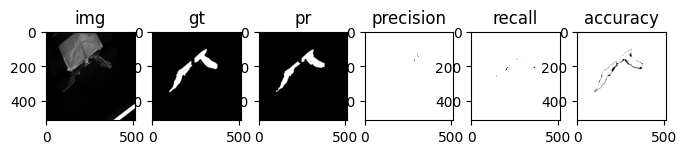

In [20]:
# base_dir = './2nd_Battery/unet'
# base_dir = './2nd_Battery/unet-mini'
base_dir = './2nd_Battery/unet-dice-loss'
# base_dir = './2nd_Battery/unet-focal-loss'
# base_dir = './2nd_Battery/unet-sgd'
# base_dir = './2nd_Battery/unet-rmsprop'
# base_dir = './2nd_Battery/unet-l1'
# base_dir = './2nd_Battery/unet-l2'
result_dir = os.path.join(base_dir, 'result')

##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_img = [f for f in lst_data if f.startswith('img')]
lst_gt = [f for f in lst_data if f.startswith('gt')]
lst_pr = [f for f in lst_data if f.startswith('pr')]

lst_img.sort()
lst_gt.sort()
lst_pr.sort()

avg_precision = 0
avg_recall = 0
avg_accuracy = 0
avg_f1 = 0

##
id = 0
length = len(lst_img)

for id in range(0, length):
    img = np.load(os.path.join(result_dir,"numpy", lst_img[id]))
    gt = np.load(os.path.join(result_dir,"numpy", lst_gt[id]))
    pr = np.load(os.path.join(result_dir,"numpy", lst_pr[id]))

    img = np.uint8(img * 255)
    gt = np.uint8(gt * 255)
    pr = np.uint8(pr * 255)

    tp = gt & pr  # True Positive: gt와 pr이 모두 1인 경우
    fp = pr & ~gt  # False Positive: pr은 1이지만 gt은 0인 경우
    tn = ~gt & ~pr  # True Negative: gt와 pr이 모두 0인 경우
    fn = ~pr & gt  # False Negative: pr은 0이지만 gt은 1인 경우

    precision = tp / (tp + fp)  # precision = TP / (TP + FP)
    recall = tp / (tp + fn) # recall = TP / (TP + FN)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    min_value = np.min(gt)
    max_value = np.max(gt)
    normalized_f1 = ((f1 - min_value) / (max_value - min_value))

    s_tp = np.sum(tp) / len(tp.flatten())
    s_fp = np.sum(fp) / len(fp.flatten())
    s_tn = np.sum(tn) / len(tn.flatten())
    s_fn = np.sum(fn) / len(fn.flatten())
    s_precision = s_tp / (s_tp + s_fp)
    s_recall = s_tp / (s_tp + s_fn)
    s_accuracy = (s_tp + s_tn) / (s_tp + s_tn + s_fp + s_fn)
    s_f1 = 2 * s_precision * s_recall / (s_precision + s_recall)

    avg_precision += s_precision
    avg_recall += s_recall
    avg_accuracy += s_accuracy
    avg_f1 += s_f1


print(f"precision: {avg_precision / length}")
print(f"recall: {avg_recall / length}")
print(f"accuracy: {avg_accuracy / length}")
print(f"f1: {avg_f1 / length}")

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(161)
plt.imshow(img, cmap='gray')
plt.title('img')

plt.subplot(162)
plt.imshow(gt, cmap='gray')
plt.title('gt')

plt.subplot(163)
plt.imshow(pr, cmap='gray')
plt.title('pr')

plt.subplot(164)
plt.imshow(precision, cmap='gray')
plt.title('precision')

plt.subplot(165)
plt.imshow(recall, cmap='gray')
plt.title('recall')

plt.subplot(166)
plt.imshow(accuracy, cmap='gray')
plt.title('accuracy')

plt.show()

# UNet
LOSS 0.2072

# UNet - Mini
LOSS 0.1324

# UNet - Dice Loss
LOSS 0.3879

# UNet - Focal Loss
LOSS 0.0112

# UNet - SGD Opt
LOSS 0.1787

# UNEt - RMSProp Opt
LOSS 0.1666

# UNet - L1 Loss
LOSS 0.0357

# UNet - L2 Loss
LOSS 0.0241


# UNet - L1 + L2 Loss
LOSS 0.0550
